In [17]:
# -*- coding: utf-8 -*-
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or
# implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#

# Time-series forecasting with Deep Learning

#### Instalation `pip install mpld3 pydot`
`mpld3` enables zooming of the matplotlib and interactive data visualizations on Jupyter notebook.

In [33]:
import numpy as np
import pandas as pd
# import pandas_datareader as pdr
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline
matplotlib.style.use('ggplot')

import seaborn as sns
sns.set(context='paper', style='whitegrid', color_codes=True)   
sns.set_palette(sns.color_palette(["#017b92", "#f97306", "#ff0000"]))  # ["green", "orange", "red"] 

import mpld3
mpld3.enable_notebook()

In [19]:
# get all targets y from a TimeseriesGenerator instance.
def get_y_from_generator(gen):
    y = None
    for i in range(len(gen)):
        batch_y = gen[i][1]
        if y is None:
            y = batch_y
        else:
            y = np.append(y, batch_y)
    y = y.reshape((-1,1))
    print(y.shape)
    return y


## Load data

(15000, 1)


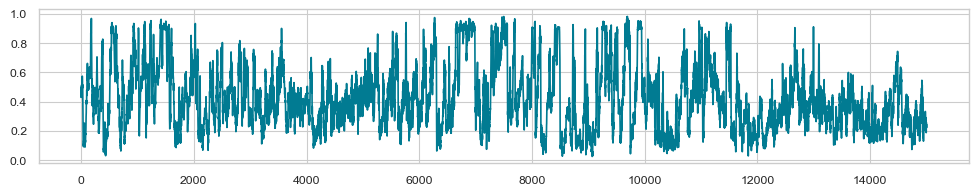

In [20]:
# n = 500
# x = np.arange(0, n, 1) 
# y = np.sin(16*np.pi*x/n) + np.cos(32*np.pi*x/n)
# noisy = np.random.rand(n)
# y = y + noisy
# data_org = y.reshape(-1, 1)

# https://www.kaggle.com/robikscube/hourly-energy-consumption?select=PJME_hourly.csv
# df = pd.read_csv('data/PJME_hourly.csv')
# df.drop('Datetime', axis=1, inplace=True)
# data = df.values
# data_org = data[:15000]

data = pd.read_csv('test.csv')
data = data['PM10 Concentration']
data = data.to_numpy()
data = data[:15000]
data = data.reshape(-1,1)

data_org = data
print(data.shape)
plt.rcParams["figure.figsize"] = (12,2)
plt.plot(data)

## Data transformation

	1. ADF :  -9.823911308266991
	2. P-Value :  5.249165342769946e-17
	3. Num Of Lags :  42


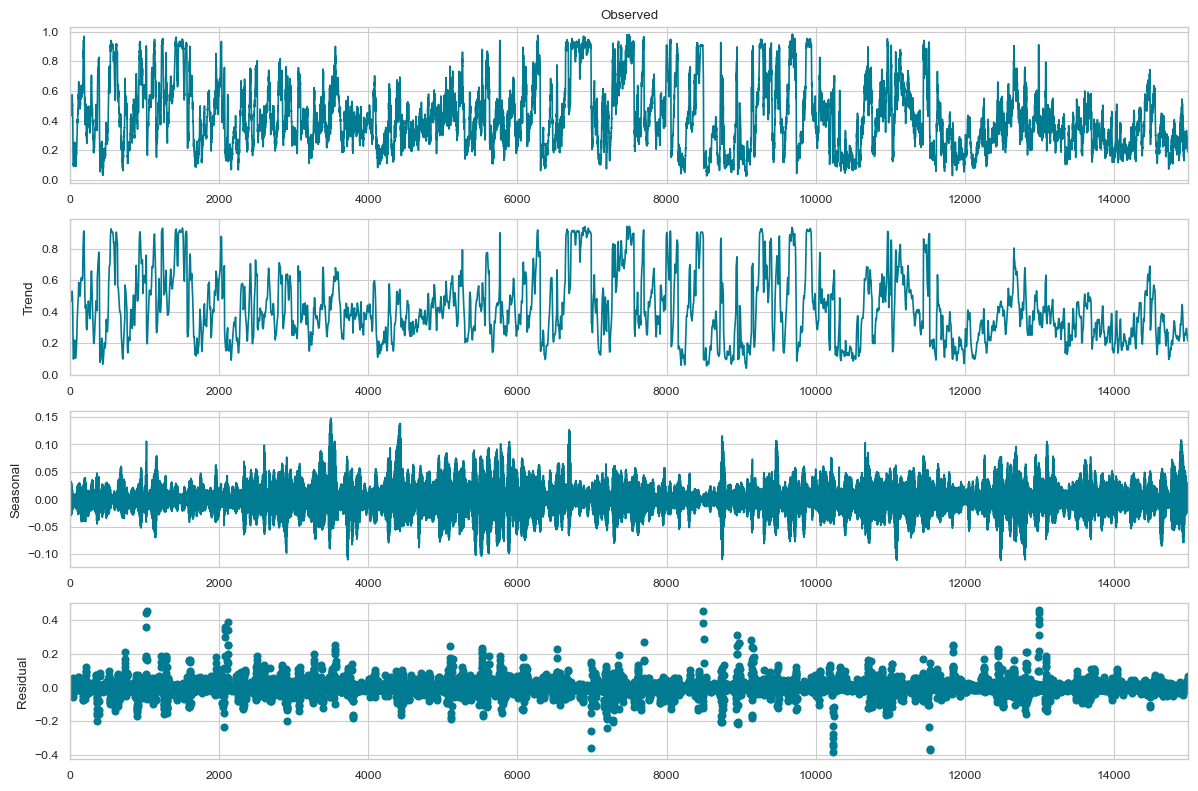

In [21]:
dftest = adfuller(data, autolag = 'AIC')
print("\t1. ADF : ",dftest[0])
print("\t2. P-Value : ", dftest[1])
print("\t3. Num Of Lags : ", dftest[2])
          
result = STL(data, period=6, robust = True).fit()
plt.rcParams["figure.figsize"] = (12,8)
result.plot()
plt.show()
data_cleaned = result.trend.reshape(-1, 1)

## Data normalization

In [22]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_trans = scaler.fit_transform(data_cleaned)

## Data splitting and time-series generator

In [23]:
train_size = int(len(data_trans) * 0.80)
test_size = len(data_trans) - train_size
train, test = data_trans[0:train_size,:], data_trans[train_size:len(data_trans),:]

look_back = 10
train_data_gen = TimeseriesGenerator(train, 
                                     train,
                                     length=look_back, 
                                     sampling_rate=1,
                                     stride=1,
                                     batch_size=1
                                    )
test_data_gen = TimeseriesGenerator(test, 
                                    test,
                                    length=look_back, 
                                    sampling_rate=1,
                                    stride=1,
                                    batch_size=1
                                   )

## Training

In [24]:
# model
x = Input(shape=(look_back, 1))
h = LSTM(units=5)(x)   
y = Dense(units=1, activation='sigmoid')(h)
model = Model(inputs=x, outputs=y)
print(model.summary())

# compile model
opt = Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mse', 'mae'])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10, 1)]           0         
                                                                 
 lstm_1 (LSTM)               (None, 5)                 140       
                                                                 
 dense_1 (Dense)             (None, 1)                 6         
                                                                 
Total params: 146
Trainable params: 146
Non-trainable params: 0
_________________________________________________________________
None


In [25]:
model.fit(train_data_gen, epochs=20, shuffle=True)

Epoch 1/20
11990/11990 [==============================] - 39s 3ms/step - loss: 0.0055 - mse: 0.0055 - mae: 0.0439
Epoch 2/20
11990/11990 [==============================] - 38s 3ms/step - loss: 8.6509e-04 - mse: 8.6509e-04 - mae: 0.0173
Epoch 3/20
11990/11990 [==============================] - 37s 3ms/step - loss: 5.6511e-04 - mse: 5.6511e-04 - mae: 0.0133
Epoch 4/20
11990/11990 [==============================] - 37s 3ms/step - loss: 4.4879e-04 - mse: 4.4879e-04 - mae: 0.0115
Epoch 5/20
11990/11990 [==============================] - 37s 3ms/step - loss: 3.8333e-04 - mse: 3.8333e-04 - mae: 0.0103
Epoch 6/20
11990/11990 [==============================] - 37s 3ms/step - loss: 3.4050e-04 - mse: 3.4050e-04 - mae: 0.0095
Epoch 7/20
11990/11990 [==============================] - 37s 3ms/step - loss: 3.1638e-04 - mse: 3.1638e-04 - mae: 0.0089
Epoch 8/20
11990/11990 [==============================] - 37s 3ms/step - loss: 2.9418e-04 - mse: 2.9418e-04 - mae: 0.0084
Epoch 9/20
11990/11990 [========

In [26]:
model.evaluate(test_data_gen)

2990/2990 [==============================] - 4s 1ms/step - loss: 2.2778e-05 - mse: 2.2778e-05 - mae: 0.0033


[2.2778081984142773e-05, 2.2778081984142773e-05, 0.0032506126444786787]

In [27]:
trainPredict = model.predict(train_data_gen)
print(trainPredict.shape)
testPredict = model.predict(test_data_gen)
print(testPredict.shape)

11990/11990 [==============================] - 13s 1ms/step
(11990, 1)
2990/2990 [==============================] - 3s 1ms/step
(2990, 1)


## Invert transformation

In [28]:
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)

In [29]:
trainY = get_y_from_generator(train_data_gen)
testY = get_y_from_generator(test_data_gen)

(11990, 1)
(2990, 1)


In [30]:
trainY = scaler.inverse_transform(trainY)
testY = scaler.inverse_transform(testY)

## Model evaluation

In [31]:
trainScore = math.sqrt(mean_squared_error(trainY[:,0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[:, 0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.01 RMSE
Test Score: 0.00 RMSE


## Plotting

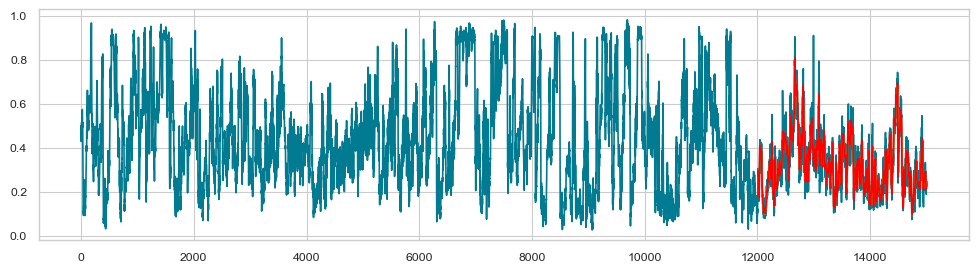

In [34]:
begin = train_size + look_back
end = begin + len(testPredict)

testYPlot = np.empty_like(data_org)
testYPlot[:, :] = np.nan
testYPlot[begin:end, :] = testY

testPredictPlot = np.empty_like(data_org)
testPredictPlot[:, :] = np.nan
testPredictPlot[begin:end, :] = testPredict

# plot baseline and predictions
plt.rcParams["figure.figsize"] = (12,3)
plt.plot(data_org)
plt.plot(testYPlot)
plt.plot(testPredictPlot)
plt.show()